In [6]:
import findspark

In [7]:
findspark.init('/home/farid/spark/')

In [8]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [9]:
import numpy as np
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt


In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [11]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config('spark.driver.host','127.0.0.1') \
    .getOrCreate()


23/05/01 15:49:26 WARN Utils: Your hostname, farid-pc resolves to a loopback address: 127.0.1.1; using 172.17.41.100 instead (on interface wlp3s0)
23/05/01 15:49:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/01 15:49:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [12]:
df=spark.read.csv('uber-raw-data-aug14.csv',header=True,inferSchema=True)


In [13]:
df.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Lon: double (nullable = true)
 |-- Base: string (nullable = true)



In [14]:
shape = (df.count(),len(df.columns))
shape

(829275, 4)

In [15]:
for i in df.columns:
    print(df.filter(df[i].isNull()).count())

0


0
0
0


In [24]:
df_final= df.select('Lat','Lon')

In [25]:
df_final.show()

+-------+--------+
|    Lat|     Lon|
+-------+--------+
|40.7366|-73.9906|
| 40.726|-73.9918|
|40.7209|-74.0507|
|40.7387|-73.9856|
|40.7323|-74.0077|
|40.7349|-74.0033|
|40.7279|-73.9542|
| 40.721|-73.9937|
|40.7195| -74.006|
|40.7448|-73.9799|
|40.7399|-74.0057|
|40.7651|-73.9683|
|40.7354|-74.0081|
|40.7339|-74.0028|
|40.7364|-74.0301|
|40.7364|-74.0301|
|40.7252|-73.9516|
|40.7433| -73.986|
|40.7437|-73.9884|
|40.7406|-74.0077|
+-------+--------+
only showing top 20 rows



In [26]:
pan = df_final.toPandas()
pan

,Lat,Lon
0,40.7366,-73.9906
1,40.7260,-73.9918
2,40.7209,-74.0507
3,40.7387,-73.9856
4,40.7323,-74.0077
...,...,...
829270,40.7552,-73.9753
829271,40.7552,-73.9753
829272,40.7617,-73.9788
829273,40.7395,-73.9889


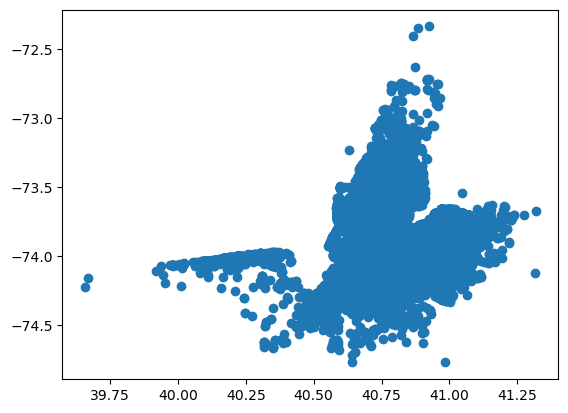

In [27]:
plt.scatter(pan['Lat'], pan['Lon'])
plt.show()

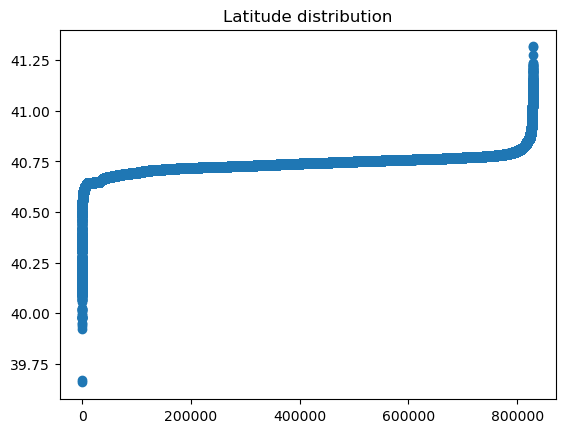

In [28]:
plt.scatter(range(pan.shape[0]), np.sort(pan.Lat.values))
plt.title("Latitude distribution")
plt.show()

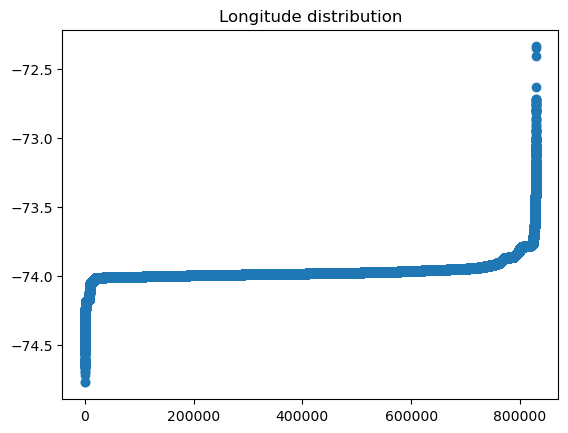

In [29]:
plt.scatter(range(pan.shape[0]), np.sort(pan.Lon.values))
plt.title("Longitude distribution")
plt.show()

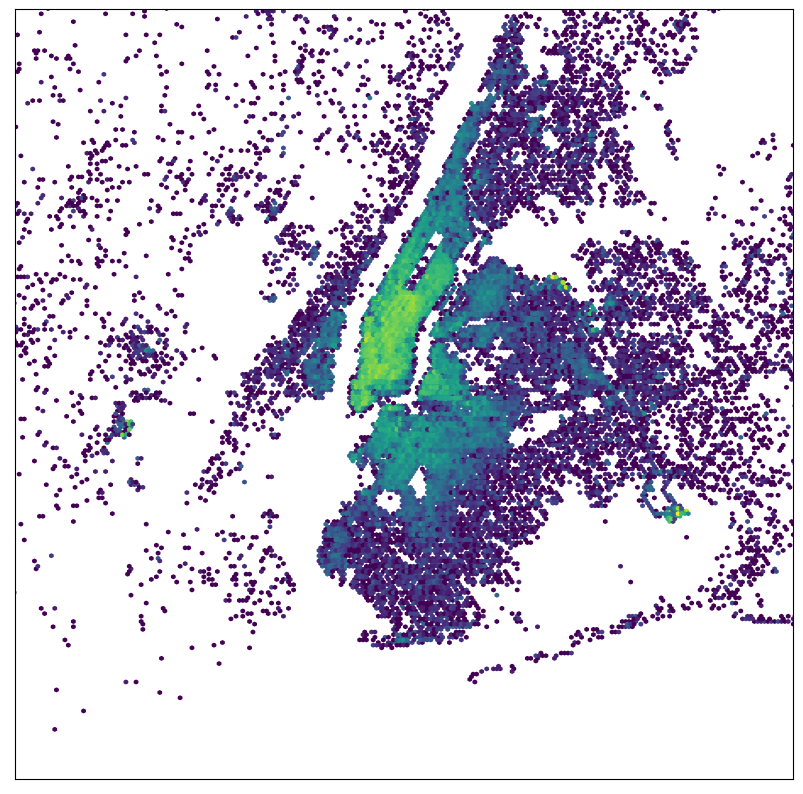

In [30]:
from mpl_toolkits.basemap import Basemap

west, south, east, north = -74.26, 40.50, -73.70, 40.92

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='i')
x, y = m(pan['Lon'].values, pan['Lat'].values)
m.hexbin(x, y, gridsize=1000,
         bins='log');

In [31]:
train,test = df_final.randomSplit([0.8,0.2],seed=10)

In [32]:
assemble1 = VectorAssembler(inputCols=train.columns,outputCol='features')

In [33]:
output1=assemble1.transform(train)

In [34]:
svm=output1.select('features')

In [35]:
svm.show()

+------------------+
|          features|
+------------------+
|[39.6569,-74.2258]|
|[39.9701,-74.0662]|
|[39.9776,-74.0651]|
| [39.9803,-74.067]|
|[39.9824,-74.0705]|
|[39.9827,-74.0681]|
|[39.9947,-74.0634]|
|[40.0188,-74.0587]|
|[40.0213,-74.0616]|
| [40.023,-74.0544]|
|[40.0563,-74.0472]|
|[40.0641,-74.0743]|
|[40.0653,-74.0462]|
| [40.067,-74.0687]|
|[40.0707,-74.0511]|
|  [40.076,-74.069]|
|[40.0786,-74.0487]|
|[40.0807,-74.0528]|
|[40.0822,-74.0564]|
|[40.0847,-74.0399]|
+------------------+
only showing top 20 rows



In [36]:
cost = []
for i in range(2, 15):
    kmeans = KMeans().setK(i).setSeed(5)
    model = kmeans.fit(svm)
    cost.append(model.summary.trainingCost) 



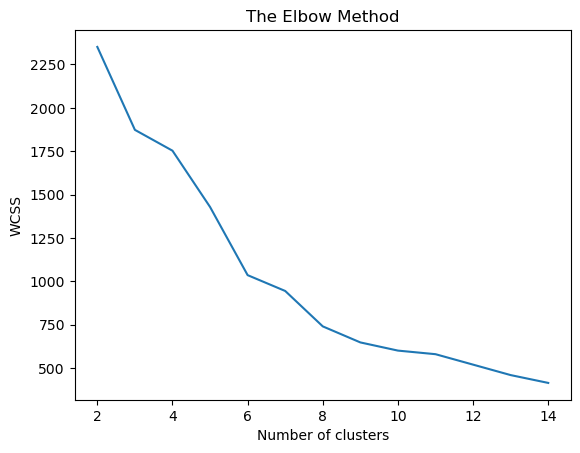

In [37]:
plt.plot(range(2, 15), cost)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [39]:
kmeans = KMeans().setK(8).setSeed(5)
model = kmeans.fit(svm)

In [40]:
test.toPandas().to_csv('test.csv',index=False)

In [43]:
model.save('/home/farid/Documents/bigdata/cluster')